# Dataset import and preprocessing

**Imports**

In [ ]:
import kagglehub, os, shutil, random, torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets


ModuleNotFoundError: No module named 'torch'

**Fixed random seed for reproducability**

In [ ]:
# fix result (taken from Monshi et al 2021)
# https://github.com/MaramMonshi/CovidXrayNet/blob/main/DataAugmentation/1-resize.ipynb 
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
SEED = 42
seed_everything(SEED)

**Dataset import**

In [ ]:
# Copy to current directory
target_dir = "chest_xray_data"

if not os.path.exists(target_dir):

    # Download the dataset
    path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

    print("Downloaded to cache:", path)

    shutil.copytree(path, target_dir)
    print(f"Dataset copied to: {target_dir}")
    
else:
    print(f"Dataset already exists at: {target_dir}")

print("\nDataset ready at:", os.path.abspath(target_dir))

Dataset already exists at: chest_xray_data

Dataset ready at: c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project3_FYSSTK3155-4155\Code\chest_xray_data


### Dataset reshuffle and train, test, val split 80/10/10

Copied from: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/discussion/485689 

In [ ]:
dataset_path = 'chest_xray_data/chest_xray'
new_dataset_path = 'chest_xray_data_split'

if not os.path.exists(new_dataset_path):
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = f'{dataset_path}/{split}/{cls}'
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        random.shuffle(all_files)

        train_files = all_files[:int(len(all_files)*0.8)]
        val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
        test_files = all_files[int(len(all_files)*0.9):]

        for file, source_folder in train_files:
            dest = f'{new_dataset_path}/train/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)

        for file, source_folder in val_files:
            dest = f'{new_dataset_path}/val/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)

        for file, source_folder in test_files:
            dest = f'{new_dataset_path}/test/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)  

    print("\nDataset ready at:", os.path.abspath(new_dataset_path))
   
else:
    print(f"Dataset already exists at: {new_dataset_path}")

Dataset already exists at: chest_xray_data_split


**Find the smallest and largest image dimensions present in the dataset** \
Used to investigate variation in size

In [ ]:
import os
from PIL import Image

dataset_path = 'chest_xray_data_split'
sizes = []

for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = f'{dataset_path}/{split}/{cls}'
        for filename in os.listdir(folder):
            img = Image.open(os.path.join(folder, filename))
            width, height = img.size
            sizes.append((width * height, width, height, filename))

sizes.sort()  # Sort by total pixels

print("Top 5 smallest images:")
for i in range(5):
    pixels, w, h, name = sizes[i]
    print(f"{name}: {w} x {h} ({pixels:,} pixels)")


sizes.sort(reverse=True)  # Sort largest first

print("\nTop 5 largest images:")
for i in range(5):
    pixels, w, h, name = sizes[i]
    print(f"{name}: {w} x {h} ({pixels:,} pixels)")

Top 5 smallest images:
person407_virus_811.jpeg: 384 x 127 (48,768 pixels)
person325_virus_660.jpeg: 400 x 138 (55,200 pixels)
person325_virus_661.jpeg: 446 x 132 (58,872 pixels)
person325_virus_659.jpeg: 445 x 140 (62,300 pixels)
person1689_bacteria_4474.jpeg: 437 x 144 (62,928 pixels)

Top 5 largest images:
NORMAL2-IM-1257-0001.jpeg: 2916 x 2583 (7,532,028 pixels)
IM-0521-0001.jpeg: 2890 x 2534 (7,323,260 pixels)
NORMAL2-IM-1018-0001.jpeg: 2694 x 2625 (7,071,750 pixels)
NORMAL2-IM-0602-0001.jpeg: 2619 x 2628 (6,882,732 pixels)
NORMAL2-IM-0030-0001.jpeg: 2517 x 2713 (6,828,621 pixels)


**Pipeline for data preprocessing**

In [ ]:
def compute_mean_std(loader):
    """Calculate mean and std of dataset"""
    mean = 0.0
    std = 0.0
    total_images = 0
    
    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_size
    
    mean /= total_images
    std /= total_images
    
    return mean.tolist(), std.tolist()

temp_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((480, 480)),
    transforms.ToTensor()
])

temp_dataset = datasets.ImageFolder(root='chest_xray_data_split/train', 
                                     transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=32, shuffle=False)

mean, std = compute_mean_std(temp_loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.48145145177841187]
Std: [0.22301341593265533]


In [ ]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# CLAHE function
def apply_clahe(img):
    img_np = np.array(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(img_np)
    return Image.fromarray(equalized)

# Training transform for generalization
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(apply_clahe),
    transforms.Resize((480, 480)),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal image flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.ColorJitter(brightness=0.3),  # Randomly adjust brightness
    transforms.ToTensor(),  # Transform image into tensor
    transforms.Normalize(mean=[mean], std=[std])
])

# Val and test transform
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(apply_clahe),
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

# Datasets
dataset_path = 'chest_xray_data_split'

train_dataset = datasets.ImageFolder(root=f'{dataset_path}/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root=f'{dataset_path}/val', transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=f'{dataset_path}/test', transform=val_test_transform)

# DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                         shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                       shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, pin_memory=True)

print(f"Classes: {train_dataset.classes}")
print(f"Input nodes: {train_dataset[0][0][0].shape[0]**2} ({train_dataset[0][0][0].shape[0]}^2)")
print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Classes: ['NORMAL', 'PNEUMONIA']
Input nodes: 230400 (480^2)
Train size: 4684
Val size: 585
Test size: 587


**Visualization of data**

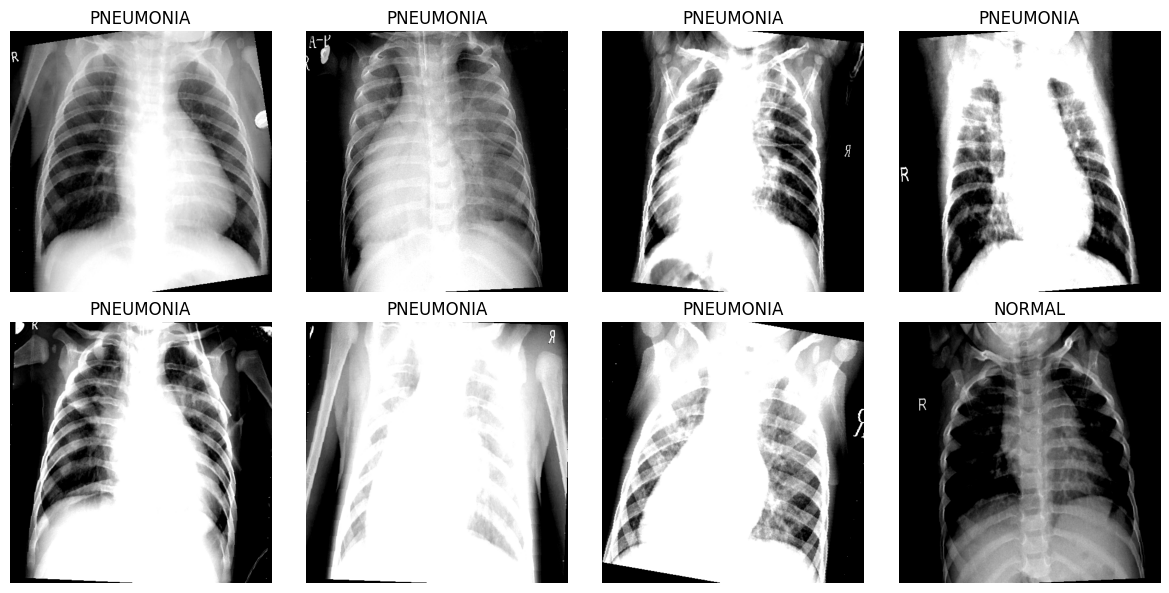

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

def denormalize(tensor):
    return torch.clamp(tensor * 0.5 + 0.5, 0, 1)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    row, col = i // 4, i % 4
    img = denormalize(images[i]).permute(1, 2, 0).cpu().numpy()
    axes[row, col].imshow(img.squeeze(), cmap='gray')
    axes[row, col].set_title(train_dataset.classes[labels[i]])
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()